<a href="https://colab.research.google.com/github/ruinhadan/FewShotLearning/blob/main/Few_Shot_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torchnet

     |████████████████████████████████| 676 kB 6.2 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29741 sha256=aac8f56b7d581cde3058f02d4f9287a38a18b6671b293a6de0b50d96b87175ce
  Stored in directory: /root/.cache/pip/wheels/93/17/b3/86db1d93e9dae198813aa79831b403e4844d67986cf93894b5
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=76ce050978411de7d54662817895b4f0dea9aec8e1a2a57ca1cac2d1fc142f11
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5710 sha256=8f57759237b3eccd27fce38bd5935b5861a87a19c0ce69ef63739297f00206e7
  Stored in directory: /root/.cache/pip/wheels/ac/5c/3a/a80e1c65880945c71fd833408cd1e9a8cb7e2f8f37620bb75b
Successfully built torchnet visdom torchfile


# Imports and Data Preprocessing

In [4]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import trange
import sklearn.metrics as skm
from sklearn.preprocessing import OneHotEncoder
import torchnet as tnt
import torch.nn.functional as F
import torch.utils.data as data
from PIL import Image
from PIL import ImageEnhance
import math
import random
import pickle
import collections

In [5]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(0)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
with open("/content/drive/MyDrive/MiniImageNet/MiniImagenet/miniImageNet_category_split_train_phase_train.pickle", 'rb') as f:
      ip_data = pickle.load(f, encoding='latin1')

# Dataset

In [8]:
class MiniImageNet(data.Dataset):
  def __init__(self, data_base, data_novel=None, phase = 'train'):
    super(MiniImageNet, self).__init__()

    self.data_base = data_base
    self.labels = data_base['labels']
    self.phase = phase
    self.data_novel = data_novel

    if self.phase=='train':
      self.label2ind = self.buildLabelIndex(self.labels) # {0:[0 to 599], 1:[600 to 1199]...}
      self.labelIds = sorted(self.label2ind.keys())      # [0....63]
      self.num_cats = len(self.labelIds)                 # 64
      self.labelIds_base = self.labelIds                 # [0....63]
      self.num_cats_base = len(self.labelIds_base)       # 64
      self.data = self.data_base['data']

    elif self.phase=='val' or self.phase=='test':          
      self.data = np.concatenate([data_base['data'], data_novel['data']], axis=0)
      self.labels = data_base['labels'] + data_novel['labels']

      self.label2ind = self.buildLabelIndex(self.labels)
      self.labelIds = sorted(self.label2ind.keys())
      self.num_cats = len(self.labelIds)

      self.labelIds_base = self.buildLabelIndex(data_base['labels']).keys()
      self.labelIds_novel = self.buildLabelIndex(data_novel['labels']).keys()
      self.num_cats_base = len(self.labelIds_base)
      self.num_cats_novel = len(self.labelIds_novel)
      intersection = set(self.labelIds_base) & set(self.labelIds_novel)
      

    mean_pix = [x/255.0 for x in [120.39586422,  115.59361427, 104.54012653]]
    std_pix = [x/255.0 for x in [70.68188272,  68.27635443,  72.54505529]]
    normalize = transforms.Normalize(mean=mean_pix, std=std_pix)

    self.transform = transforms.Compose([
                    transforms.RandomCrop(84, padding=8),
                    transforms.RandomHorizontalFlip(),
                    lambda x: np.asarray(x),
                    transforms.ToTensor(),
                    normalize
                ])
    
    if phase != 'train':
      self.transform = transforms.Compose([
                    lambda x: np.asarray(x),
                    transforms.ToTensor(),
                    normalize
                ])
      
  def buildLabelIndex(self, labels):
    label2inds = {}
    for idx, label in enumerate(labels):
        if label not in label2inds:
            label2inds[label] = []
        label2inds[label].append(idx)

    return label2inds

  def __getitem__(self, index):
    img, label = self.data[index], self.labels[index]
    img = Image.fromarray(img)
    img = self.transform(img)
    return img, label

  def __len__(self):
    return len(self.data)



# Feature Extractor & Classifier

In [9]:
class C128F(nn.Module):
    def __init__(self, x_dim=3):
        super(C128F, self).__init__()
        self.encoder = nn.Sequential(
            self.conv_block(x_dim, 64),
            self.conv_block(64, 64),
            self.conv_block(64, 128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

In [10]:
class FeatExemplarAvgBlock(nn.Module):
    def __init__(self, nFeat):
        super(FeatExemplarAvgBlock, self).__init__()

    def forward(self, features_train, labels_train):
        labels_train_transposed = labels_train.transpose(1,2)
        weight_novel = torch.bmm(labels_train_transposed, features_train)
        weight_novel = weight_novel.div(
            labels_train_transposed.sum(dim=2, keepdim=True).expand_as(weight_novel))
        return weight_novel

In [11]:
class LinearDiag(nn.Module):
    def __init__(self, num_features, bias=False):
        super(LinearDiag, self).__init__()
        weight = torch.FloatTensor(num_features).fill_(1).to(device) # initialize to the identity transform
        self.weight = nn.Parameter(weight, requires_grad=True).to(device)

        if bias:
            bias = torch.FloatTensor(num_features).fill_(0).to(device)
            self.bias = nn.Parameter(bias, requires_grad=True).to(device)
        else:
            self.register_parameter('bias', None)

    def forward(self, X):
        assert(X.dim()==2 and X.size(1)==self.weight.size(0))
        out = X * self.weight.expand_as(X)
        if self.bias is not None:
            out = out + self.bias.expand_as(out)
        return out

In [12]:
class AttentionBasedBlock(nn.Module):
    def __init__(self, nFeat, nK, scale_att=10.0):
        super(AttentionBasedBlock, self).__init__()
        self.nFeat = nFeat
        self.queryLayer = nn.Linear(nFeat, nFeat)
        self.queryLayer.weight.data.copy_(torch.eye(nFeat, nFeat) + torch.randn(nFeat, nFeat)*0.001)
        self.queryLayer.bias.data.zero_()
        scale_att = torch.FloatTensor(1).fill_(scale_att).to(device)
        self.scale_att = nn.Parameter(scale_att, requires_grad=True).to(device)
        wkeys = torch.FloatTensor(nK, nFeat).normal_(0.0, np.sqrt(2.0/nFeat)).to(device)
        self.wkeys = nn.Parameter(wkeys, requires_grad=True).to(device)


    def forward(self, features_train, labels_train, weight_base, Kbase):
        batch_size, num_train_examples, num_features = features_train.size()
        nKbase = weight_base.size(1) # [batch_size x nKbase x num_features]
        labels_train_transposed = labels_train.transpose(1,2)
        nKnovel = labels_train_transposed.size(1) # [batch_size x nKnovel x num_train_examples]

        features_train = features_train.view(
            batch_size*num_train_examples, num_features)
        Qe = self.queryLayer(features_train)
        Qe = Qe.view(batch_size, num_train_examples, self.nFeat)
        Qe = F.normalize(Qe, p=2, dim=Qe.dim()-1, eps=1e-12)

        wkeys = self.wkeys[Kbase.reshape(-1)] # the keys of the base categoreis
        wkeys = F.normalize(wkeys, p=2, dim=wkeys.dim()-1, eps=1e-12)
        # Transpose from [batch_size x nKbase x nFeat] to
        # [batch_size x self.nFeat x nKbase]
        wkeys = wkeys.view(batch_size, nKbase, self.nFeat).transpose(1,2)

        # Compute the attention coeficients
        # batch matrix multiplications: AttentionCoeficients = Qe * wkeys ==>
        # [batch_size x num_train_examples x nKbase] =
        #   [batch_size x num_train_examples x nFeat] * [batch_size x nFeat x nKbase]
        AttentionCoeficients = self.scale_att * torch.bmm(Qe, wkeys)
        AttentionCoeficients = F.softmax(AttentionCoeficients.view(batch_size*num_train_examples, nKbase))
        AttentionCoeficients = AttentionCoeficients.view(batch_size, num_train_examples, nKbase)

        # batch matrix multiplications: weight_novel = AttentionCoeficients * weight_base ==>
        # [batch_size x num_train_examples x num_features] =
        #   [batch_size x num_train_examples x nKbase] * [batch_size x nKbase x num_features]
        weight_novel = torch.bmm(AttentionCoeficients, weight_base)
        # batch matrix multiplications: weight_novel = labels_train_transposed * weight_novel ==>
        # [batch_size x nKnovel x num_features] =
        #   [batch_size x nKnovel x num_train_examples] * [batch_size x num_train_examples x num_features]
        weight_novel = torch.bmm(labels_train_transposed, weight_novel)
        weight_novel = weight_novel.div(
            labels_train_transposed.sum(dim=2, keepdim=True).expand_as(weight_novel))

        return weight_novel

In [13]:
class Classifier(nn.Module):
  def __init__(self, gen_type=None):
    super(Classifier, self).__init__()

    self.nFeat = 128*5*5 # 3200
    self.nKall = 64
    self.nKbase = 64 if gen_type is None else 59
    self.nKnovel = 5
    self.gen_type = gen_type

    weight_base = torch.FloatTensor(self.nKall, self.nFeat).normal_(0.0, np.sqrt(2.0/self.nFeat)).to(device) # 64 * 3200
    self.weight_base = nn.Parameter(weight_base, requires_grad=True).to(device)
    bias = torch.FloatTensor(1).fill_(0).to(device)
    self.bias = nn.Parameter(bias, requires_grad=True).to(device) # torch.tensor([0])
    scale_cls = torch.FloatTensor(1).fill_(10.0).to(device)
    self.scale_cls = nn.Parameter(scale_cls, requires_grad=True).to(device)

    if self.gen_type=='feat_avg':

      self.favgblock = FeatExemplarAvgBlock(self.nFeat)
      self.wnLayerFavg = LinearDiag(self.nFeat, bias=True)
    
    elif self.gen_type=='attn':

      self.favgblock = FeatExemplarAvgBlock(self.nFeat)
      self.attblock = AttentionBasedBlock(self.nFeat, self.nKall)
      self.wnLayerFavg = LinearDiag(self.nFeat)
      self.wnLayerWatt = LinearDiag(self.nFeat)
    
  def get_classification_weights(self, features_train=None, labels_train=None, Kbase_ids=None, batch_size=8):
    Kbase_ids = np.asarray([[i for i in range(64)] for j in range(batch_size)]) if Kbase_ids is None else Kbase_ids
    weight_base = self.weight_base[Kbase_ids.reshape(-1)]
    #print(Kbase_ids.shape)
    weight_base = weight_base.view(batch_size, self.nKbase, -1)

    if features_train is None:
      return weight_base
    
    _, num_train_examples, num_channels = features_train.size()
    features_train = F.normalize(features_train, p=2, dim=features_train.dim()-1, eps=1e-12)
    if self.gen_type == 'feat_avg':
      weight_novel_avg = self.favgblock(features_train, labels_train)
      weight_novel = self.wnLayerFavg(weight_novel_avg.view(batch_size * self.nKnovel, num_channels))
      weight_novel = weight_novel.view(batch_size, self.nKnovel, num_channels)
    
    elif self.gen_type=='attn':
      weight_novel_avg = self.favgblock(features_train, labels_train)
      weight_novel_avg = self.wnLayerFavg(weight_novel_avg.view(batch_size * self.nKnovel, num_channels))
      weight_base_tmp = F.normalize(weight_base, p=2, dim=weight_base.dim()-1, eps=1e-12)

      weight_novel_att = self.attblock(features_train, labels_train, weight_base_tmp, Kbase_ids)
      weight_novel_att = self.wnLayerWatt(weight_novel_att.view(batch_size * self.nKnovel, num_channels)      )
      weight_novel = weight_novel_avg + weight_novel_att
      weight_novel = weight_novel.view(batch_size, self.nKnovel, num_channels)
    
    w = torch.cat((weight_base,weight_novel),1)
    return w   
    

  def apply_classification_weights(self, features, cls_weights):
    features = F.normalize(features, p=2, dim=features.dim()-1, eps=1e-12) # 8 * 1 * 3200
    cls_weights = F.normalize(cls_weights, p=2, dim=cls_weights.dim()-1, eps=1e-12) # 8 * 64 * 3200    
    cls_scores = self.scale_cls * torch.baddbmm(self.bias.view(1, 1, 1),features, cls_weights.transpose(1,2)) # transpose to 8 * 3200 * 64
    # 8 * [1 * 3200 x 3200 * 64 => 1 * 64 + bias]
    return cls_scores # 8 * 1 * 64

  def forward(self, features_test = None, features_train = None, labels_train=None, Kbase_ids=None, batch_size=8): 
    self.nKbase = len(Kbase_ids[0]) if Kbase_ids is not None else 64
    cls_weights = self.get_classification_weights(features_train, labels_train, Kbase_ids, batch_size)
    features_test = features_test.view(batch_size, 1 if features_train is None else len(features_test[0]), self.nFeat) 
    cls_scores = self.apply_classification_weights(features_test, cls_weights)
    
    return cls_scores
    

# Train Stage 1 - Training the feature extractor & base class classifier

In [31]:
BATCH_SIZE = 8
EPOCHS = 100

In [32]:
input_data = MiniImageNet(ip_data)
dataloader = torch.utils.data.DataLoader(input_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [33]:
feature_extractor = C128F().to(device)
base_classifier = Classifier().to(device)

In [17]:
feature_extractor.load_state_dict(torch.load("/content/drive/MyDrive/MiniImageNet/MiniImagenet/feat_0.00001_150.pth"))
base_classifier.load_state_dict(torch.load("/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_0.00001_150.pth"))

<All keys matched successfully>

In [34]:
opt_feat = optim.SGD(feature_extractor.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
opt_clas = optim.SGD(base_classifier.parameters(), lr=0.1,  momentum=0.9, weight_decay=5e-4, nesterov=True)
lossfn = nn.CrossEntropyLoss()

In [18]:
opt_feat = optim.Adam(feature_extractor.parameters(), lr=0.000001)
opt_clas = optim.Adam(base_classifier.parameters(), lr=0.000001)
lossfn = nn.CrossEntropyLoss()

In [ ]:
feature_extractor.train()

C128F(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(

In [ ]:
loss_per_epoch = []
for epoch in trange(EPOCHS):
  sum_of_loss = 0.0
  for X,Y in dataloader:
    X = X.to(device)
    Y = torch.tensor(Y).to(device)
    opt_feat.zero_grad()
    opt_clas.zero_grad()
    output = base_classifier(feature_extractor(X))
    loss = lossfn(output.view(8, 64), Y)
    sum_of_loss += loss.detach()
    loss.backward()
    opt_feat.step()
    opt_clas.step()
    del X, Y, output
  print("Epoch #"+str(epoch)+" Loss:"+str(sum_of_loss.item()/len(dataloader)))
  loss_per_epoch.append(sum_of_loss/len(dataloader))
  with open('/content/drive/MyDrive/MiniImageNet/loss_t1_SGD.txt', 'a') as f:
    f.write('\n'+str(sum_of_loss.item()/len(dataloader)))
    
# plt.plot(loss_per_epoch)
# plt.xlabel('Epochs')
# plt.ylabel('Cross Entropy Loss')
# plt.show()

  1%|          | 1/100 [01:22<2:15:19, 82.01s/it]

Epoch #0 Loss:3.3473614501953124


  2%|▏         | 2/100 [02:44<2:14:04, 82.09s/it]

Epoch #1 Loss:2.9933424886067708


  3%|▎         | 3/100 [04:05<2:12:31, 81.97s/it]

Epoch #2 Loss:2.927745157877604


  4%|▍         | 4/100 [05:28<2:11:16, 82.05s/it]

Epoch #3 Loss:2.894186808268229


  5%|▌         | 5/100 [06:50<2:09:48, 81.99s/it]

Epoch #4 Loss:2.873554890950521


  6%|▌         | 6/100 [08:12<2:08:44, 82.18s/it]

Epoch #5 Loss:2.852427978515625


  7%|▋         | 7/100 [09:34<2:07:14, 82.09s/it]

Epoch #6 Loss:2.8499788411458336


  8%|▊         | 8/100 [10:56<2:05:56, 82.14s/it]

Epoch #7 Loss:2.849950764973958


  9%|▉         | 9/100 [12:19<2:04:40, 82.20s/it]

Epoch #8 Loss:2.8431406656901044


 10%|█         | 10/100 [13:41<2:03:15, 82.18s/it]

Epoch #9 Loss:2.843577880859375


 11%|█         | 11/100 [15:03<2:01:58, 82.23s/it]

Epoch #10 Loss:2.8409965006510416


 12%|█▏        | 12/100 [16:26<2:00:43, 82.31s/it]

Epoch #11 Loss:2.843892822265625


 13%|█▎        | 13/100 [17:47<1:59:09, 82.18s/it]

Epoch #12 Loss:2.8458042399088543


 14%|█▍        | 14/100 [19:10<1:57:58, 82.30s/it]

Epoch #13 Loss:2.8340474446614583


 15%|█▌        | 15/100 [20:32<1:56:39, 82.35s/it]

Epoch #14 Loss:2.8310701497395834


 16%|█▌        | 16/100 [21:55<1:55:23, 82.43s/it]

Epoch #15 Loss:2.8333758544921874


 17%|█▋        | 17/100 [23:17<1:53:52, 82.32s/it]

Epoch #16 Loss:2.8320906575520834


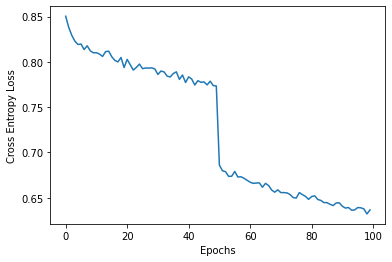

In [ ]:
with open('/content/drive/MyDrive/MiniImageNet/loss_t1_SGD.txt', 'r') as f:
  loss_per_epoch = f.readlines()

loss_per_epoch = [float(x) for x in loss_per_epoch]

plt.plot(loss_per_epoch)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Saving models' weights

In [ ]:
torch.save(feature_extractor.state_dict(), "/content/drive/MyDrive/MiniImageNet/MiniImagenet/feat_SGD.pth")
torch.save(base_classifier.state_dict(), "/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_SGD.pth")
torch.save(base_classifier.state_dict()['weight_base'], "/content/drive/MyDrive/MiniImageNet/MiniImagenet/wts_base_SGD.pt")

# Evaluating Feature Extractor

In [23]:
feature_extractor.load_state_dict(torch.load("/content/drive/MyDrive/MiniImageNet/MiniImagenet/feat_0.00001_200.pth"))
base_classifier.load_state_dict(torch.load("/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_0.00001_200.pth"))

<All keys matched successfully>

In [25]:
with open("/content/drive/MyDrive/MiniImageNet/MiniImagenet/miniImageNet_category_split_train_phase_test.pickle", 'rb') as f:
      validation_data = pickle.load(f, encoding='latin1')

In [26]:
val_data = MiniImageNet(validation_data)
val_dataloader = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [27]:
feature_extractor.eval()
acc = 0
cnt = 0
for X,Y in val_dataloader:
  X = X.to(device)
  Y = Y.to(device)
  output = base_classifier(feature_extractor(X))
  pred  = torch.argmax(output.view(8,64),dim=1)
  acc += skm.accuracy_score(Y.cpu().detach().numpy(),pred.cpu().detach().numpy())
  cnt += 1

print('Base class accuracy: ', acc/cnt)

Base class accuracy:  0.6527604166666666


# Train Stage 2 - Training the Few-shot classification weight generator based on feature averaging

## Defining the dataloader

In [20]:
class FewShotDataloader():
    def __init__(self,
                 dataset,
                 nKnovel=5, # number of novel categories.
                 nKbase=-1, # number of base categories.
                 nExemplars=5, # number of training examples per novel category.
                 nTestNovel=15*5, # number of test examples for all the novel/base categories.
                 nTestBase=15*5,  # 3 * nKnovel for train, 15 * nKnovel for test
                 batch_size=1, # number of training episodes per batch.
                 epoch_size=10, # number of batches per epoch.
                 ):

        self.dataset = dataset
        self.nKnovel = nKnovel
        self.nKbase = nKbase if nKbase >= 0 else 64
        self.phase = self.dataset.phase
        self.nExemplars = nExemplars
        self.nTestNovel = nTestNovel
        self.nTestBase = nTestBase
        self.batch_size = batch_size
        self.epoch_size = epoch_size
        self.is_eval_mode = (self.phase=='test') or (self.phase=='val')

    def sampleImageIdsFrom(self, cat_id, sample_size=5):

        return random.sample(self.dataset.label2ind[cat_id], sample_size)

    def sampleCategories(self, cat_set, sample_size=5):
        
        if cat_set=='base':
            labelIds = self.dataset.labelIds_base
        elif cat_set=='novel':
            labelIds = self.dataset.labelIds_novel

        assert(len(labelIds) >= sample_size)        # In case number of labels % 5 != 0        
        return random.sample(labelIds, sample_size)

    def sample_base_and_novel_categories(self, nKbase, nKnovel):
        
        if self.is_eval_mode:            
            Kbase = sorted(self.sampleCategories('base', nKbase))            
            Knovel = sorted(self.sampleCategories('novel', nKnovel))
        else:            
            cats_ids = self.sampleCategories('base', nKnovel+nKbase)            
            random.shuffle(cats_ids)
            Knovel = sorted(cats_ids[:nKnovel])       # FAKE novel
            Kbase = sorted(cats_ids[nKnovel:])        # Remaining base
            #print("Novel: ",Knovel, "Base: ", Kbase)

        return Kbase, Knovel                          # Class ids

    def sample_test_examples_for_base_categories(self, Kbase, nTestBase):
        
        Tbase = []
        if len(Kbase) > 0:
            
            KbaseIndices = np.random.choice(np.arange(len(Kbase)), size=nTestBase, replace=True)
            KbaseIndices, NumImagesPerCategory = np.unique(
                KbaseIndices, return_counts=True)

            for Kbase_idx, NumImages in zip(KbaseIndices, NumImagesPerCategory):
                imd_ids = self.sampleImageIdsFrom(
                    Kbase[Kbase_idx], sample_size=NumImages)
                Tbase += [(img_id, Kbase_idx) for img_id in imd_ids]

        assert(len(Tbase) == nTestBase)

        return Tbase

    def sample_train_and_test_examples_for_novel_categories(
            self, Knovel, nTestNovel, nExemplars, nKbase):
        

        if len(Knovel) == 0:
            return [], []

        nKnovel = len(Knovel)
        Tnovel = []
        Exemplars = []
        assert((nTestNovel % nKnovel) == 0)
        nEvalExamplesPerClass = nTestNovel // nKnovel

        for Knovel_idx in range(len(Knovel)):
            imd_ids = self.sampleImageIdsFrom(
                Knovel[Knovel_idx],
                sample_size=(nEvalExamplesPerClass + nExemplars))

            imds_tnovel = imd_ids[:nEvalExamplesPerClass]
            imds_ememplars = imd_ids[nEvalExamplesPerClass:]

            Tnovel += [(img_id, nKbase + Knovel_idx) for img_id in imds_tnovel]
            Exemplars += [(img_id, nKbase + Knovel_idx) for img_id in imds_ememplars]
        assert(len(Tnovel) == nTestNovel)
        assert(len(Exemplars) == len(Knovel) * nExemplars)
        random.shuffle(Exemplars)

        return Tnovel, Exemplars

    def sample_episode(self):
       
        nKnovel = self.nKnovel
        nKbase = self.nKbase
        nTestNovel = self.nTestNovel
        nTestBase = self.nTestBase
        nExemplars = self.nExemplars

        Kbase, Knovel = self.sample_base_and_novel_categories(nKbase, nKnovel)
        Tbase = self.sample_test_examples_for_base_categories(Kbase, nTestBase)
        Tnovel, Exemplars = self.sample_train_and_test_examples_for_novel_categories(
            Knovel, nTestNovel, nExemplars, nKbase)

       
        Test = Tbase + Tnovel
        random.shuffle(Test)
        Kall = Kbase + Knovel

        return Exemplars, Test, Kall, nKbase              # Exemplars - 5-way 5-shot, Test - 15 + 15, Kall - shuffle[0...63], nKbase - 59

    def createExamplesTensorData(self, examples):
        
        images = torch.stack(
            [self.dataset[img_idx][0] for img_idx, _ in examples], dim=0)
        labels = torch.LongTensor([label for _, label in examples])
        return images, labels

    def get_iterator(self, epoch=0):
        rand_seed = epoch
        random.seed(rand_seed)
        np.random.seed(rand_seed)
        def load_function(iter_idx):
            Exemplars, Test, Kall, nKbase = self.sample_episode()
            Xt, Yt = self.createExamplesTensorData(Test)
            Kall = torch.LongTensor(Kall)
            if len(Exemplars) > 0:
                Xe, Ye = self.createExamplesTensorData(Exemplars)
                return Xe, Ye, Xt, Yt, Kall, nKbase
            else:
                return Xt, Yt, Kall, nKbase

        tnt_dataset = tnt.dataset.ListDataset(
            elem_list=range(self.epoch_size), load=load_function)
        data_loader = tnt_dataset.parallel(
            batch_size=self.batch_size,
            # num_workers=(0 if self.is_eval_mode else self.num_workers),
            shuffle=(False if self.is_eval_mode else True))

        return data_loader

    def __call__(self, epoch=0):
        return self.get_iterator(epoch)

    def __len__(self):
        return (self.epoch_size / self.batch_size)


Sample episode
```
torch.Size([8, 25, 3, 84, 84]) - Xe
torch.Size([8, 25]) - Ye
torch.Size([8, 30, 3, 84, 84]) - Xt
torch.Size([8, 30]) - Yt
torch.Size([8, 64]) - Kall
torch.Size([8]) - nKbase
```

## Instantiating classifier & loading base weights

In [ ]:
input_data = MiniImageNet(ip_data)

In [21]:
dataloader = FewShotDataloader(
    input_data, 
    nKnovel=5, 
    nKbase=59, 
    nExemplars=5, 
    nTestNovel=15, 
    nTestBase=15, 
    batch_size=8, 
    epoch_size=800
)

In [ ]:
feature_extractor = C128F().to(device)
feature_extractor.load_state_dict(torch.load('/content/drive/MyDrive/MiniImageNet/MiniImagenet/feat_0.0001_200.pth'))

<All keys matched successfully>

In [ ]:
few_shot_classifier = Classifier(gen_type="attn").to(device)

In [ ]:
few_shot_classifier_dict = few_shot_classifier.state_dict()
base_classifier_wts = torch.load('/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_0.0001.pth')
modified_state_dict = {}
for k in few_shot_classifier_dict.keys():
  if k in base_classifier_wts.keys():
    modified_state_dict[k] = base_classifier_wts[k]
  else:
    modified_state_dict[k] = few_shot_classifier_dict[k]
modified_state_dict = collections.OrderedDict(modified_state_dict)
few_shot_classifier_dict.update(modified_state_dict)
few_shot_classifier.load_state_dict(few_shot_classifier_dict)
few_shot_classifier.state_dict()

OrderedDict([('weight_base',
              tensor([[ 0.0442,  0.1156,  0.0272,  ..., -0.0061, -0.0129,  0.0302],
                      [ 0.0823,  0.1109,  0.0731,  ...,  0.0195,  0.0213, -0.0029],
                      [ 0.0269,  0.0225,  0.0528,  ...,  0.1251,  0.1220, -0.0510],
                      ...,
                      [-0.1039, -0.1648, -0.1487,  ...,  0.0539,  0.0338,  0.0795],
                      [ 0.0023,  0.1287,  0.0958,  ...,  0.0716,  0.1468,  0.1630],
                      [ 0.0049,  0.0388,  0.0630,  ...,  0.0174, -0.0111, -0.0681]],
                     device='cuda:0')),
             ('bias', tensor([-2.4290], device='cuda:0')),
             ('scale_cls', tensor([44.0892], device='cuda:0')),
             ('attblock.scale_att', tensor([10.], device='cuda:0')),
             ('attblock.wkeys',
              tensor([[-0.0313,  0.0350,  0.0308,  ...,  0.0114, -0.0255,  0.0478],
                      [-0.0146, -0.0135,  0.0034,  ..., -0.0427,  0.0055, -0.0198],
       

In [ ]:
opt_clas = optim.Adam(few_shot_classifier.parameters(), lr=0.0001)
lossfn = nn.CrossEntropyLoss()

In [ ]:
EPOCHS=100

loss_per_epoch = []
feature_extractor.eval()

for param in feature_extractor.parameters():
  param.requires_grad = False

for epoch in trange(EPOCHS):
  sum_of_loss = 0.0

  for Xe,Ye,Xt,Yt,Kall,nKbase in dataloader():
    Xe = Xe.to(device).view(8 * 25, 3, 84, 84)
    features_train = feature_extractor(Xe)
    features_train = features_train.resize(8,25,3200)
    del Xe

    Xt = Xt.to(device).view(8 * 30, 3, 84, 84)
    features_test = feature_extractor(Xt)
    features_test = features_test.resize(8,30,3200)
    Ye = torch.tensor(Ye).to(device)
    labels_train = []

    for labels in Ye:
      enc = OneHotEncoder()
      labels_train.append(enc.fit_transform(labels.cpu().numpy().reshape(-1,1)).toarray())

    labels_train = torch.tensor(labels_train).to(device)

    opt_clas.zero_grad()

    output = few_shot_classifier(features_test, features_train.float(), labels_train.float(), Kbase_ids=Kall[:,:59], batch_size=8)
    
    Yt = torch.tensor(Yt).to(device).view(8*30)
    loss = lossfn(output.view(8*30,64), Yt)
    sum_of_loss+=loss.detach()

    loss.backward()    
    opt_clas.step()

  print("Epoch #"+str(epoch)+" Loss:"+str(sum_of_loss.item()/100))  
  loss_per_epoch.append(sum_of_loss/100)
  with open('/content/drive/MyDrive/MiniImageNet/loss_t2_attn_0.0001.txt', 'a') as f:
    f.write('\n'+str(sum_of_loss.item()/100))
    
# plt.plot(loss_per_epoch)
# plt.xlabel('Epochs')
# plt.ylabel('Cross Entropy Loss')
# plt.show()

  1%|          | 1/100 [00:43<1:11:06, 43.10s/it]

Epoch #0 Loss:1.1465919494628907


  2%|▏         | 2/100 [01:25<1:10:09, 42.96s/it]

Epoch #1 Loss:1.0857844543457031


  3%|▎         | 3/100 [02:08<1:09:22, 42.92s/it]

Epoch #2 Loss:1.058219223022461


  4%|▍         | 4/100 [02:51<1:08:24, 42.75s/it]

Epoch #3 Loss:1.0243619537353517


  5%|▌         | 5/100 [03:33<1:07:37, 42.71s/it]

Epoch #4 Loss:1.0150029754638672


  6%|▌         | 6/100 [04:16<1:06:51, 42.67s/it]

Epoch #5 Loss:1.0014380645751952


  7%|▋         | 7/100 [04:58<1:05:57, 42.55s/it]

Epoch #6 Loss:0.9799132537841797


  8%|▊         | 8/100 [05:41<1:05:11, 42.52s/it]

Epoch #7 Loss:0.9687138366699218


  9%|▉         | 9/100 [06:23<1:04:31, 42.55s/it]

Epoch #8 Loss:0.9636550903320312


 10%|█         | 10/100 [07:06<1:03:52, 42.58s/it]

Epoch #9 Loss:0.9547669219970704


 11%|█         | 11/100 [07:49<1:03:15, 42.64s/it]

Epoch #10 Loss:0.9435520935058593


 12%|█▏        | 12/100 [08:31<1:02:27, 42.59s/it]

Epoch #11 Loss:0.9383528900146484


 13%|█▎        | 13/100 [09:14<1:01:43, 42.57s/it]

Epoch #12 Loss:0.9296582794189453


 14%|█▍        | 14/100 [09:56<1:01:01, 42.58s/it]

Epoch #13 Loss:0.9186029052734375


 15%|█▌        | 15/100 [10:39<1:00:17, 42.56s/it]

Epoch #14 Loss:0.9169963836669922


 16%|█▌        | 16/100 [11:22<59:38, 42.60s/it]  

Epoch #15 Loss:0.8995966339111328


 17%|█▋        | 17/100 [12:04<58:59, 42.65s/it]

Epoch #16 Loss:0.8992731475830078


 18%|█▊        | 18/100 [12:47<58:16, 42.64s/it]

Epoch #17 Loss:0.8932193756103516


 19%|█▉        | 19/100 [13:30<57:41, 42.73s/it]

Epoch #18 Loss:0.8842625427246094


 20%|██        | 20/100 [14:13<57:00, 42.75s/it]

Epoch #19 Loss:0.8848774719238282


 21%|██        | 21/100 [14:56<56:19, 42.78s/it]

Epoch #20 Loss:0.8749813842773437


 22%|██▏       | 22/100 [15:38<55:30, 42.70s/it]

Epoch #21 Loss:0.8780233001708985


 23%|██▎       | 23/100 [16:21<54:46, 42.68s/it]

Epoch #22 Loss:0.8627275085449219


 24%|██▍       | 24/100 [17:04<54:06, 42.72s/it]

Epoch #23 Loss:0.8624803161621094


 25%|██▌       | 25/100 [17:46<53:19, 42.66s/it]

Epoch #24 Loss:0.8527590942382812


 26%|██▌       | 26/100 [18:29<52:35, 42.64s/it]

Epoch #25 Loss:0.8502377319335938


 27%|██▋       | 27/100 [19:11<51:49, 42.59s/it]

Epoch #26 Loss:0.8443107604980469


 28%|██▊       | 28/100 [19:54<51:07, 42.61s/it]

Epoch #27 Loss:0.8371894073486328


 29%|██▉       | 29/100 [20:37<50:28, 42.65s/it]

Epoch #28 Loss:0.8409717559814454


 30%|███       | 30/100 [21:19<49:40, 42.58s/it]

Epoch #29 Loss:0.838304672241211


 31%|███       | 31/100 [22:01<48:54, 42.53s/it]

Epoch #30 Loss:0.8292378234863281


 32%|███▏      | 32/100 [22:44<48:10, 42.51s/it]

Epoch #31 Loss:0.8281447601318359


 33%|███▎      | 33/100 [23:26<47:23, 42.44s/it]

Epoch #32 Loss:0.816662826538086


 34%|███▍      | 34/100 [24:09<46:40, 42.43s/it]

Epoch #33 Loss:0.8251645660400391


 35%|███▌      | 35/100 [24:51<45:54, 42.38s/it]

Epoch #34 Loss:0.814389419555664


 36%|███▌      | 36/100 [25:33<45:11, 42.36s/it]

Epoch #35 Loss:0.8101661682128907


 37%|███▋      | 37/100 [26:16<44:29, 42.37s/it]

Epoch #36 Loss:0.8083081817626954


 38%|███▊      | 38/100 [26:58<43:49, 42.41s/it]

Epoch #37 Loss:0.8032029724121094


 39%|███▉      | 39/100 [27:40<43:07, 42.42s/it]

Epoch #38 Loss:0.8076356506347656


 40%|████      | 40/100 [28:23<42:29, 42.49s/it]

Epoch #39 Loss:0.800742416381836


 41%|████      | 41/100 [29:06<41:52, 42.59s/it]

Epoch #40 Loss:0.8036363983154297


 42%|████▏     | 42/100 [29:49<41:13, 42.64s/it]

Epoch #41 Loss:0.7943238830566406


 43%|████▎     | 43/100 [30:31<40:29, 42.62s/it]

Epoch #42 Loss:0.7835118865966797


 44%|████▍     | 44/100 [31:14<39:49, 42.68s/it]

Epoch #43 Loss:0.790740966796875


 45%|████▌     | 45/100 [31:57<39:04, 42.63s/it]

Epoch #44 Loss:0.7855281829833984


 46%|████▌     | 46/100 [32:39<38:18, 42.57s/it]

Epoch #45 Loss:0.7836209106445312


 47%|████▋     | 47/100 [33:22<37:35, 42.55s/it]

Epoch #46 Loss:0.7762865447998046


 48%|████▊     | 48/100 [34:04<36:50, 42.50s/it]

Epoch #47 Loss:0.7773297882080078


 49%|████▉     | 49/100 [34:46<36:02, 42.41s/it]

Epoch #48 Loss:0.7771942901611328


 50%|█████     | 50/100 [35:28<35:17, 42.34s/it]

Epoch #49 Loss:0.7683669281005859


 51%|█████     | 51/100 [36:10<34:32, 42.29s/it]

Epoch #50 Loss:0.7746745300292969


 52%|█████▏    | 52/100 [36:53<33:48, 42.27s/it]

Epoch #51 Loss:0.771399917602539


 53%|█████▎    | 53/100 [37:35<33:05, 42.25s/it]

Epoch #52 Loss:0.7660927581787109


 54%|█████▍    | 54/100 [38:17<32:24, 42.27s/it]

Epoch #53 Loss:0.7589009857177734


 55%|█████▌    | 55/100 [39:00<31:43, 42.29s/it]

Epoch #54 Loss:0.7586592102050781


 56%|█████▌    | 56/100 [39:42<31:03, 42.35s/it]

Epoch #55 Loss:0.7622734069824219


 57%|█████▋    | 57/100 [40:24<30:20, 42.33s/it]

Epoch #56 Loss:0.7505474853515625


 58%|█████▊    | 58/100 [41:07<29:39, 42.38s/it]

Epoch #57 Loss:0.7526702117919922


 59%|█████▉    | 59/100 [41:49<28:55, 42.34s/it]

Epoch #58 Loss:0.7572760772705078


 60%|██████    | 60/100 [42:31<28:13, 42.33s/it]

Epoch #59 Loss:0.7531883239746093


 61%|██████    | 61/100 [43:14<27:32, 42.37s/it]

Epoch #60 Loss:0.7414000701904296


 62%|██████▏   | 62/100 [43:56<26:50, 42.38s/it]

Epoch #61 Loss:0.7464344024658203


 63%|██████▎   | 63/100 [44:39<26:11, 42.49s/it]

Epoch #62 Loss:0.7437579345703125


 64%|██████▍   | 64/100 [45:22<25:31, 42.55s/it]

Epoch #63 Loss:0.7501676940917968


 65%|██████▌   | 65/100 [46:04<24:49, 42.56s/it]

Epoch #64 Loss:0.7460569763183593


 66%|██████▌   | 66/100 [46:47<24:10, 42.66s/it]

Epoch #65 Loss:0.7352407836914062


 67%|██████▋   | 67/100 [47:30<23:29, 42.72s/it]

Epoch #66 Loss:0.7360650634765625


 68%|██████▊   | 68/100 [48:13<22:44, 42.65s/it]

Epoch #67 Loss:0.7355065155029297


 69%|██████▉   | 69/100 [48:55<21:58, 42.55s/it]

Epoch #68 Loss:0.7361734771728515


 70%|███████   | 70/100 [49:37<21:14, 42.48s/it]

Epoch #69 Loss:0.7305329895019531


 71%|███████   | 71/100 [50:19<20:28, 42.37s/it]

Epoch #70 Loss:0.7296633148193359


 72%|███████▏  | 72/100 [51:02<19:47, 42.40s/it]

Epoch #71 Loss:0.7235158538818359


 73%|███████▎  | 73/100 [51:44<19:03, 42.35s/it]

Epoch #72 Loss:0.7282904052734375


 74%|███████▍  | 74/100 [52:26<18:21, 42.35s/it]

Epoch #73 Loss:0.7253614044189454


 75%|███████▌  | 75/100 [53:09<17:41, 42.48s/it]

Epoch #74 Loss:0.7209054565429688


 76%|███████▌  | 76/100 [53:52<17:00, 42.54s/it]

Epoch #75 Loss:0.7236116790771484


 77%|███████▋  | 77/100 [54:34<16:16, 42.46s/it]

Epoch #76 Loss:0.7200167846679687


 78%|███████▊  | 78/100 [55:16<15:33, 42.45s/it]

Epoch #77 Loss:0.716713638305664


 79%|███████▉  | 79/100 [55:59<14:51, 42.47s/it]

Epoch #78 Loss:0.7192257690429688


 80%|████████  | 80/100 [56:42<14:10, 42.51s/it]

Epoch #79 Loss:0.7153083801269531


 81%|████████  | 81/100 [57:24<13:29, 42.60s/it]

Epoch #80 Loss:0.7108322906494141


 82%|████████▏ | 82/100 [58:07<12:47, 42.64s/it]

Epoch #81 Loss:0.7092552185058594


 83%|████████▎ | 83/100 [58:50<12:05, 42.65s/it]

Epoch #82 Loss:0.7116793823242188


 84%|████████▍ | 84/100 [59:33<11:24, 42.80s/it]

Epoch #83 Loss:0.7079996490478515


 85%|████████▌ | 85/100 [1:00:16<10:43, 42.91s/it]

Epoch #84 Loss:0.7091478729248046


 86%|████████▌ | 86/100 [1:00:59<10:01, 42.97s/it]

Epoch #85 Loss:0.708238525390625


 87%|████████▋ | 87/100 [1:01:42<09:19, 43.00s/it]

Epoch #86 Loss:0.7018488311767578


 88%|████████▊ | 88/100 [1:02:25<08:35, 42.97s/it]

Epoch #87 Loss:0.7035836791992187


 89%|████████▉ | 89/100 [1:03:08<07:51, 42.83s/it]

Epoch #88 Loss:0.7045451354980469


 90%|█████████ | 90/100 [1:03:50<07:07, 42.78s/it]

Epoch #89 Loss:0.6965798950195312


 91%|█████████ | 91/100 [1:04:33<06:24, 42.77s/it]

Epoch #90 Loss:0.6964947509765625


 92%|█████████▏| 92/100 [1:05:16<05:42, 42.87s/it]

Epoch #91 Loss:0.6916747283935547


 93%|█████████▎| 93/100 [1:05:59<05:00, 42.93s/it]

Epoch #92 Loss:0.694790267944336


 94%|█████████▍| 94/100 [1:06:42<04:17, 42.86s/it]

Epoch #93 Loss:0.6976782989501953


 95%|█████████▌| 95/100 [1:07:25<03:33, 42.78s/it]

Epoch #94 Loss:0.6907790374755859


 96%|█████████▌| 96/100 [1:08:07<02:51, 42.76s/it]

Epoch #95 Loss:0.6965191650390625


 97%|█████████▋| 97/100 [1:08:50<02:08, 42.74s/it]

Epoch #96 Loss:0.6895405578613282


 98%|█████████▊| 98/100 [1:09:32<01:25, 42.64s/it]

Epoch #97 Loss:0.6900896453857421


 99%|█████████▉| 99/100 [1:10:15<00:42, 42.65s/it]

Epoch #98 Loss:0.6885320281982422


100%|██████████| 100/100 [1:10:57<00:00, 42.58s/it]

Epoch #99 Loss:0.6912133026123047


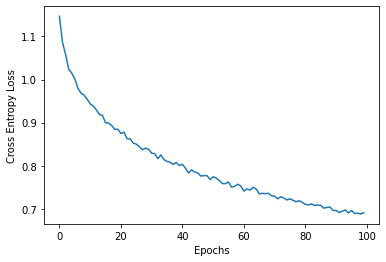

In [ ]:
with open('/content/drive/MyDrive/MiniImageNet/loss_t2_attn_0.0001.txt', 'r') as f:
  loss_per_epoch = f.readlines()

loss_per_epoch = [float(x) for x in loss_per_epoch]

plt.plot(loss_per_epoch)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

## Saving model weights

In [ ]:
torch.save(few_shot_classifier.state_dict(), "/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_stage2_attn_0.0001.pth")

## Evaluating base class accuracy

In [22]:
with open("/content/drive/MyDrive/MiniImageNet/MiniImagenet/miniImageNet_category_split_train_phase_val.pickle", 'rb') as f:
      validation_data = pickle.load(f, encoding='latin1')

In [ ]:
BATCH_SIZE=8

In [ ]:
val_data = MiniImageNet(validation_data)
val_dataloader = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
base_classifier = Classifier().to(device)

In [ ]:
base_classifier_dict = base_classifier.state_dict()
few_shot_classifier_wts = torch.load('/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_stage2_attn_0.0001.pth')
modified_state_dict = {}
for k in base_classifier_dict.keys():
  if k in few_shot_classifier_wts.keys():
    modified_state_dict[k] = few_shot_classifier_wts[k]
  else:
    modified_state_dict[k] = base_classifier_dict[k]
modified_state_dict = collections.OrderedDict(modified_state_dict)
base_classifier_dict.update(modified_state_dict)
base_classifier.load_state_dict(base_classifier_dict)
base_classifier.state_dict()

OrderedDict([('weight_base',
              tensor([[ 0.0919,  0.1499,  0.0825,  ...,  0.0016, -0.0138,  0.0282],
                      [ 0.0882,  0.0779,  0.0135,  ..., -0.0295, -0.0274, -0.0244],
                      [ 0.0169,  0.0320,  0.0608,  ...,  0.1098,  0.1522, -0.0396],
                      ...,
                      [-0.0844, -0.1494, -0.1572,  ...,  0.0526, -0.0098,  0.0527],
                      [-0.0111,  0.1204,  0.0740,  ...,  0.0536,  0.1448,  0.1783],
                      [ 0.0128,  0.0542,  0.0665,  ...,  0.0023,  0.0281, -0.0064]],
                     device='cuda:0')),
             ('bias', tensor([-2.9767], device='cuda:0')),
             ('scale_cls', tensor([45.0475], device='cuda:0'))])

In [ ]:
feature_extractor.eval()
acc = 0
cnt = 0
for X,Y in val_dataloader:
  X = X.to(device)
  Y = Y.to(device)
  output = base_classifier(feature_extractor(X))
  pred  = torch.argmax(output.view(8,64),dim=1)
  acc += skm.accuracy_score(Y.cpu().detach().numpy(),pred.cpu().detach().numpy())
  cnt += 1

print('Base class accuracy: ', acc/cnt)

Base class accuracy:  0.6286979166666666


## Evaluating novel class accuracy

In [ ]:
with open("/content/drive/MyDrive/MiniImageNet/MiniImagenet/miniImageNet_category_split_val.pickle", 'rb') as f:
      novel_validation_data = pickle.load(f, encoding='latin1')

In [ ]:
val_data_novel = MiniImageNet(data_base=validation_data, data_novel=novel_validation_data, phase='val')

In [ ]:
val_novel_dataloader = FewShotDataloader(
    val_data_novel, 
    nKnovel=5, 
    nKbase=0, # Novel class alone
    nExemplars=5, 
    nTestNovel=75, 
    nTestBase=0, 
    batch_size=1, 
    epoch_size=200
)

In [ ]:
BATCH_SIZE=1

In [ ]:
feature_extractor.eval()
acc = 0
cnt = 0
for Xe,Ye,Xt,Yt,Kall,nKbase in val_novel_dataloader():
    Xe = Xe.to(device).view(1 * 25, 3, 84, 84)
    features_train = feature_extractor(Xe)
    features_train = features_train.resize(1,25,3200)
    del Xe

    Xt = Xt.to(device).view(1 * 75, 3, 84, 84)
    features_test = feature_extractor(Xt)
    features_test = features_test.resize(1,75,3200)
    Ye = torch.tensor(Ye).to(device)
    labels_train = []

    for labels in Ye:
      enc = OneHotEncoder()
      labels_train.append(enc.fit_transform(labels.cpu().numpy().reshape(-1,1)).toarray())

    labels_train = torch.tensor(labels_train).to(device)

    output = few_shot_classifier(features_test, features_train.float(), labels_train.float(), Kbase_ids=None, batch_size=1)
    
    Yt = torch.tensor(Yt).to(device).view(1*75)
    #print(output.size())
    pred  = torch.argmax(output[:,:,64:].view(75,5),dim=1)
    acc += skm.accuracy_score(Yt.cpu().detach().numpy(),pred.cpu().detach().numpy())
    cnt += 1

print('Novel class accuracy: ', acc/cnt)

Novel class accuracy:  0.6916666666666663


## Evaluating both base and novel accuracy

In [ ]:
val_both_dataloader = FewShotDataloader(
    val_data_novel, 
    nKnovel=5, 
    nKbase=64, 
    nExemplars=5, 
    nTestNovel=75, 
    nTestBase=75, 
    batch_size=1, 
    epoch_size=200
)

In [ ]:
feature_extractor.eval()
acc = 0
cnt = 0
for Xe,Ye,Xt,Yt,Kall,nKbase in val_both_dataloader():
    Xe = Xe.to(device).view(1 * 25, 3, 84, 84)
    features_train = feature_extractor(Xe)
    features_train = features_train.resize(1,25,3200)
    del Xe

    Xt = Xt.to(device).view(1 * 150, 3, 84, 84)
    features_test = feature_extractor(Xt)
    features_test = features_test.resize(1,150,3200)
    Ye = torch.tensor(Ye).to(device)
    labels_train = []

    for labels in Ye:
      enc = OneHotEncoder()
      labels_train.append(enc.fit_transform(labels.cpu().numpy().reshape(-1,1)).toarray())

    labels_train = torch.tensor(labels_train).to(device)

    output = few_shot_classifier(features_test, features_train.float(), labels_train.float(), Kbase_ids=None, batch_size=1)
    
    Yt = torch.tensor(Yt).to(device).view(1*150)
    #print(output.size())
    pred  = torch.argmax(output.view(150,69),dim=1)
    acc += skm.accuracy_score(Yt.cpu().detach().numpy(),pred.cpu().detach().numpy())
    cnt += 1

print('Both base and novel class accuracy: ', acc/cnt)

Both base and novel class accuracy:  0.5439000000000004


Training Stage 1 - 100 epochs, Training Stage 2 - 200 epochs

* **Base class accuracy**:  61.19%
* **Novel class accuracy**:  66.14%
* **Both base and novel class accuracy**:  50.22%




Training Stage 1 - 100 epochs, Training Stage 2 - 10 epochs [Attn]


*   Base Class accuracy: 62
*   Novel : 66
*   Both : 50.93





Train Stage 2 100 attn
both: 52

Train Stage 1 (0.0001) 100 epochs Stage 2 100 epochs
Base: 63
Novel: 69
Both: 54